Train all models and save preds

In [1]:
import os
import re
import numpy as np
import pandas as pd
from pandas import DataFrame
import sklearn
from sklearn.tree import DecisionTreeRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
import sklearn.tree as tree
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import Lasso, Ridge, LinearRegression
import pickle
import warnings

In [2]:
from thon.churn_functions import out_eval, bake, modernize, simple_split

In [3]:
# global params
split = (119, 122)
scoring = 'neg_root_mean_squared_error'
raw_scoring = sklearn.metrics.mean_squared_error

In [6]:
# lasso
from thon.models.lasso import lasso_vars
lass_f = lasso_vars(scoring = 'neg_root_mean_squared_error',
                   split = (119, 122))
lass_f

['altsales_lag3',
 'cbpy30_lag3',
 'fedsurplus_lag3',
 'GT_lag3',
 'industry_lag9',
 'laborpart_lag3',
 'manufinv_lag12',
 'month',
 'newhouses_lag3']

In [7]:
from thon.models.linear import linear_model
lm = linear_model((119, 122), 
                  feature_selection=lass_f)

940.3456226779965 3548.6905948230956


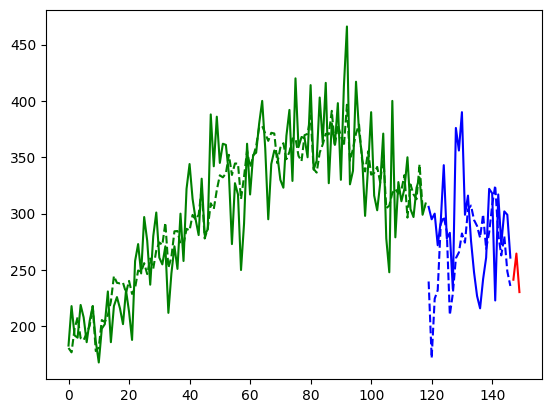

In [8]:
out_eval(lm, sklearn.metrics.mean_squared_error)

In [9]:
from thon.models.tree import decision_tree
dtree = decision_tree(split = (119, 121),
                          scoring = 'neg_mean_absolute_error')

Fitting 5 folds for each of 6 candidates, totalling 30 fits
{'model__max_depth': 4}


16.437081499266377 48.97471264367816


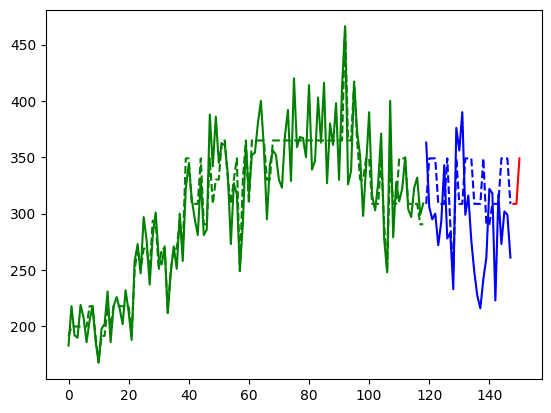

In [10]:
out_eval(dtree, sklearn.metrics.mean_absolute_error)

In [11]:
# random forest
from thon.models.random import random_forest
rf = random_forest(split = (119, 122),
                  feature_selection=lass_f)

682.0879595096271 2141.6323195825726


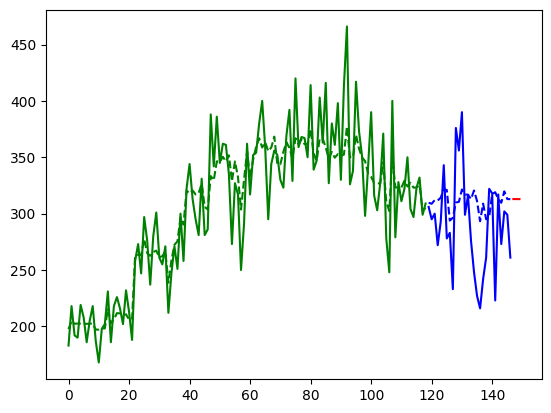

In [12]:
out_eval(rf, sklearn.metrics.mean_squared_error)

In [23]:
from thon.models.lstm import run_lstm
n, model = run_lstm(split = (119, 122),
                     num_epochs = 200,
                     learning_rate = 0.01,
                     hidden_size = 32,
                     n_layers = 1, 
                     feature_selection = lass_f)

C:\Users\keato\AppData\Local\Programs\Python\Python310\lib\site-packages\torch\nn\modules\rnn.py:67: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


Epoch: 1, train loss: 0.39354, test loss: 0.29853
Epoch: 21, train loss: 0.01743, test loss: 0.01441
Epoch: 41, train loss: 0.01430, test loss: 0.01302
Epoch: 61, train loss: 0.00931, test loss: 0.01219
Epoch: 81, train loss: 0.00607, test loss: 0.01209
Epoch: 101, train loss: 0.00469, test loss: 0.01231
Epoch: 121, train loss: 0.00445, test loss: 0.01242
Epoch: 141, train loss: 0.00442, test loss: 0.01237
Epoch: 161, train loss: 0.00440, test loss: 0.01218
Epoch: 181, train loss: 0.00438, test loss: 0.01207


939.4277123652042 2585.499717274431


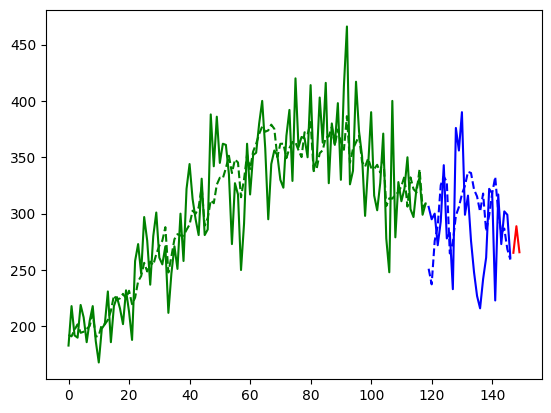

In [24]:
out_eval(n, sklearn.metrics.mean_squared_error)

In [21]:
from thon.models.gru import run_gru
gru, model = run_gru(split = (119, 122),
                     num_epochs = 200,
                     learning_rate = 0.01,
                     hidden_size = 32,
                     n_layers = 1, 
                     feature_selection = lass_f)

C:\Users\keato\AppData\Local\Programs\Python\Python310\lib\site-packages\torch\nn\modules\rnn.py:67: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=1 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


Epoch: 1, train loss: 0.49267, test loss: 0.33937
Epoch: 21, train loss: 0.01215, test loss: 0.01882
Epoch: 41, train loss: 0.01214, test loss: 0.01612
Epoch: 61, train loss: 0.00655, test loss: 0.01315
Epoch: 81, train loss: 0.00532, test loss: 0.01261
Epoch: 101, train loss: 0.00486, test loss: 0.01255
Epoch: 121, train loss: 0.00470, test loss: 0.01248
Epoch: 141, train loss: 0.00460, test loss: 0.01240
Epoch: 161, train loss: 0.00454, test loss: 0.01237
Epoch: 181, train loss: 0.00450, test loss: 0.01240


960.7223794418387 2683.2325645906885


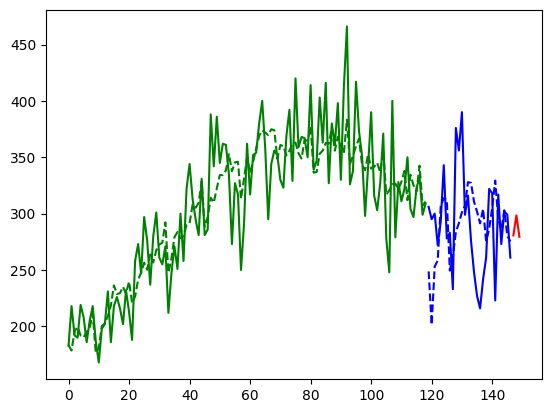

In [22]:
out_eval(gru, sklearn.metrics.mean_squared_error)

In [1]:
from sklearn.metrics import r2_score
from thon.churn_functions import out_eval, bake, modernize, simple_split

def run_selection(split = (119, 122),
                  scoring = 'neg_root_mean_squared_error'):
    
    # lasso
    from thon.models.selection.lasso import lasso_vars
    lass_f = lasso_vars(split = split,
                        scoring = scoring)
    
    from thon.models.selection.random_imp import random_perm
    rperm = random_perm(split = split)
    
    return (lass_f, rperm)

In [12]:
def run_prediction(split = (119, 122),
            scoring = 'neg_root_mean_squared_error',
            raw_scoring = r2_score):
#lm
    from thon.models.prediction.linear import linear_model
    lm = linear_model(split = split, 
                  feature_selection = lass_f)
    
    lm_scores = out_eval(lm, raw_scoring, verbose = 1)
    
    from thon.models.prediction.tree import decision_tree
    dtree = decision_tree(split = split,
                          scoring = scoring)
    
    tree_scores = out_eval(dtree, raw_scoring, verbose = 1)
    
    # random forest
    from thon.models.prediction.random import random_forest
    rf = random_forest(split = split,
                      feature_selection=lass_f)
    
    rf_scores = out_eval(rf, raw_scoring,verbose = 1)
    
    from thon.models.prediction.lstm import run_lstm
    n, model = run_lstm(split = split,
                        num_epochs = 200,
                        learning_rate = 0.01,
                        hidden_size = 12,
                        n_layers = 1, 
                        feature_selection = lass_f)
    
    lstm_scores = out_eval(n, raw_scoring, verbose = 2)
    
    from thon.models.prediction.gru import run_gru
    gru, model = run_gru(split = split,
                         num_epochs =1000,
                         learning_rate = 0.01,
                         hidden_size = 12,
                         n_layers = 1, 
                         feature_selection = lass_f,
                        verbose = 2)
    
    gru_scores = out_eval(gru, raw_scoring, verbose = 2)
    
    return lm_scores, tree_scores, rf_scores, lstm_scores, gru_scores

In [11]:
lass_f, rperm = run_selection()

Epoch: 1, train loss: 0.42785, test loss: 0.31003
Epoch: 101, train loss: 0.00941, test loss: 0.02007
Epoch: 201, train loss: 0.00776, test loss: 0.02560
Epoch: 301, train loss: 0.00759, test loss: 0.02536
Epoch: 401, train loss: 0.00752, test loss: 0.02503
Epoch: 501, train loss: 0.00748, test loss: 0.02483
Epoch: 601, train loss: 0.00744, test loss: 0.02502
Epoch: 701, train loss: 0.00742, test loss: 0.02550
Epoch: 801, train loss: 0.00739, test loss: 0.02624
Epoch: 901, train loss: 0.00736, test loss: 0.02718
999 0.0073235975578427315 0.027182938531041145


((0.670350343686392, -0.3662946047718827),
 (0.7316915195262481, -0.40068465956058086),
 (0.8028793511903642, -0.7268528860788832),
 (0.6778076555516399, -0.9333133119844721),
 (0.6911127224926341, -2.046694610327892))

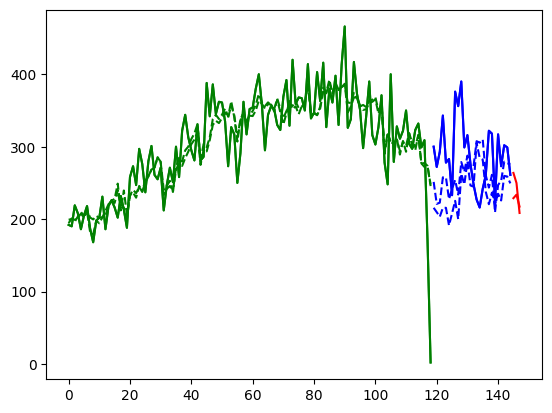

In [13]:
run_prediction()